OPTIMIZATION RESULTS
Optimal Beta Exponent: 0.0015
Calculated F-Metric:  3.3615e+08
95% Confidence Interval: [3.0752e+08, 3.6672e+08]


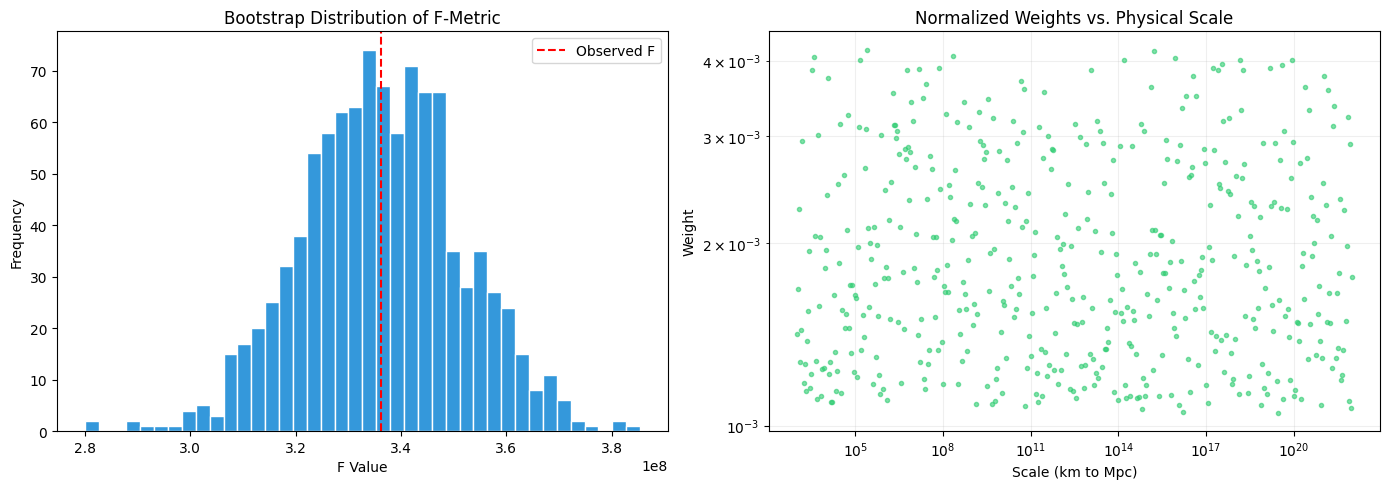

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# =================================================================
# 1. CORE FUNCTIONS
# =================================================================

def calculate_f_metric(residuals, scales, densities, sigma_sq, beta):
    """
    Calculates the aggregation metric F based on Eq A22 and A25.
    """
    # Eq A22: Weighting with scale-weighting exponent beta
    weights = (1.0 / sigma_sq) * (scales**-beta)
    normalized_weights = weights / np.sum(weights)

    # Eq A25: Aggregation Metric
    f_metric = np.sum(normalized_weights * residuals * densities)
    return f_metric, normalized_weights

def optimize_beta(scales, sigma_sq):
    """
    Section 15: Optimizing beta to minimize scale-dominance variance.
    Ensures that no single scale (e.g., the very small or very large)
    completely dominates the metric.
    """
    def objective(beta):
        weights = (1.0 / sigma_sq) * (scales**-beta)
        norm_w = weights / np.sum(weights)
        # Minimize the variance of the log-weights to spread influence evenly
        return np.var(np.log10(norm_w + 1e-20))

    res = minimize_scalar(objective, bounds=(0, 3), method='bounded')
    return res.x

# =================================================================
# 2. SIMULATION & EXECUTION
# =================================================================

def run_simulation():
    # --- Setup Mock Data ---
    np.random.seed(42)
    n = 500
    scales = np.geomspace(1e3, 1e22, n)      # Distance scale: km to Mpc
    densities = np.random.uniform(1e-5, 1e5, n)
    sigma_sq = np.random.uniform(0.5, 2.0, n)

    # Inject signal (Eq A24)
    # The signal is hidden within noise but proportional to density
    noise = np.random.normal(0, np.sqrt(sigma_sq))
    signal = 0.1 * densities
    residuals = noise + signal

    # --- Step 1: Optimize Beta ---
    beta_opt = optimize_beta(scales, sigma_sq)

    # --- Step 2: Calculate Primary Metric ---
    f_val, weights = calculate_f_metric(residuals, scales, densities, sigma_sq, beta_opt)

    # --- Step 3: Bootstrap Verification ---
    # Resample with replacement to find the 95% Confidence Interval
    boot_results = []
    for _ in range(1000):
        idx = np.random.choice(n, n, replace=True)
        res_b, _ = calculate_f_metric(residuals[idx], scales[idx], densities[idx], sigma_sq[idx], beta_opt)
        boot_results.append(res_b)

    # --- Step 4: Output Results ---
    ci_low, ci_high = np.percentile(boot_results, [2.5, 97.5])

    print("="*50)
    print(f"OPTIMIZATION RESULTS")
    print("="*50)
    print(f"Optimal Beta Exponent: {beta_opt:.4f}")
    print(f"Calculated F-Metric:  {f_val:.4e}")
    print(f"95% Confidence Interval: [{ci_low:.4e}, {ci_high:.4e}]")
    print("="*50)

    # --- Step 5: Visualization ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Distribution of Bootstrap Results
    ax1.hist(boot_results, bins=40, color='#3498db', edgecolor='white')
    ax1.axvline(f_val, color='red', linestyle='--', label='Observed F')
    ax1.set_title("Bootstrap Distribution of F-Metric")
    ax1.set_xlabel("F Value")
    ax1.set_ylabel("Frequency")
    ax1.legend()

    # Weight Distribution across Scales
    ax2.loglog(scales, weights, color='#2ecc71', marker='.', linestyle='none', alpha=0.6)
    ax2.set_title("Normalized Weights vs. Physical Scale")
    ax2.set_xlabel("Scale (km to Mpc)")
    ax2.set_ylabel("Weight")
    ax2.grid(True, which="both", ls="-", alpha=0.2)

    plt.tight_layout()
    plt.show()

# Run everything
if __name__ == "__main__":
    run_simulation()